In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import t 
import seaborn as sns
import matplotlib.patches  as patches
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from collections import namedtuple
sns.set_style('whitegrid')
random.seed(30)
np.random.seed(45)
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (12.5, 9),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Type I and Type II errors:

__Type I error__ is concluding that there is a significant difference between Treatment and Control when there is no real difference.<br>
OR<
is the rejection of a true null hypothesis (false positive).

__Type II error ($\beta$)__ is concluding that there is no significant difference between Treatment and Control when there actually is a difference.<br> 
OR
is the non-rejection of false null hypothesis (false negative).'


__Power__ is the probability of decting a difference between the variants(Treatment and Control) when there is a significant difference between them,
OR <br>
<font size = 4>
Power = $P$(reject $H_{0}$ | $H_{1}$ is true) = 1 - $P$(fail to reject $H_{0}$ | $H_{0}$ is false) = 1 - Type II Error ($\beta$)
</font>
<br> <br>
Alternatively, with the assumption of desired confidence level 95% (or $\alpha = 0.05$), <br>
<font size = 4>
$Power_{\delta}$ = $P(|T| \geq 1.96 |$ true diff is $\delta$) </font> <br>
Where, T = T statistic from T-test and delta is the difference in the means


__Minimum detectable effect__: It is the quantified amount/magnitude of the observation we are interested in. For example, when comparing between two variants (Control and Treatment), what is the minimum detectable effect? Answers, what is the quantified magnitude of the effect (Treatment) we introduced? These are generally based on heuristics or goals of your experiment. For example, you believe that there would be a conversion rate increment of 3% in your treatment group. 

In [2]:
%%HTML
<style>
td {
  font-size: 20px
}
</style>

|     | $H_{0}$ true | $H_{0}$ false |
| --- | --- | --- |
| Do not Reject $H_{0}$     | correct inference  ($P = 1 - \alpha$)     |    Type II  error ($P = \beta$)  |
| Reject  $H_{0}$ | Type I error ($P = \alpha$) | correct inference/ Power ($P = 1 -\beta$) |

Text(0.5, 1.0, 'Type I and Type II error in Hypothesis Testing')

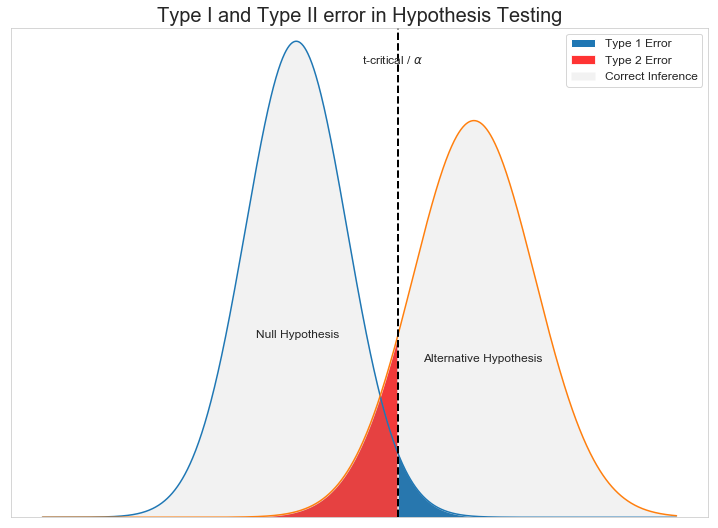

In [13]:
x = np.arange(-5,7.5, .01)
y1 = stats.norm.pdf(x)
y2 = stats.norm.pdf(x,loc=3.5, scale=1.2 )  

plt.plot(x, y1)
plt.plot(x,y2)


plt.axvline(x= 2, color = "black", linewidth = 2,linestyle='--')

#type1
#type1x = np.arange(1.4,1.66,0.01)
#plt.fill_between(type1x, stats.norm.pdf(type1x),  
#                 stats.norm.pdf(type1x,loc=3.5, scale=1.2 ),label='Type 1 Error'  )

#type1
type1x = np.arange(2,7.5, .01)
plt.fill_between(type1x, stats.norm.pdf(type1x),label='Type 1 Error'  )

#type2
type2x = np.arange(-2,2,0.01)
plt.fill_between(x=type2x, 
                 y1= stats.norm.pdf(type2x,loc=3.5, scale=1.2) ,
                 facecolor='red', label='Type 2 Error',
                 alpha=0.8)

plt.fill_between(x=np.arange(-5,2,0.01), y1= stats.norm.pdf(np.arange(-5,2,0.01)) ,
                 facecolor='grey', label='Correct Inference',
                 alpha=0.1)

plt.fill_between(x=x, y1= stats.norm.pdf(x,loc=3.5, scale=1.2) ,
                 facecolor='grey',alpha=0.1)


plt.legend()
plt.grid(False)
plt.yticks([])
plt.xticks([])
plt.ylim([0,0.41])

plt.text(x=-0.8, y=0.15, s= "Null Hypothesis",fontsize=12)
plt.text(x=2.5, y=0.13, s= "Alternative Hypothesis", fontsize=12)
plt.text(x= 1.3, y = 0.38, s = r't-critical / $\alpha$',fontsize=12)

plt.title('Type I and Type II error in Hypothesis Testing', fontsize=20)

### Effect size: 

It is the quantified amount/magnitude of the observation we are interested in. For example, when comparing between two variants (Control and Treatment), what is the effect size? Answers, what is the quantified magnitude of the effect (Treatment) we introduced? 

#### Cohen's d:
Cohen's d is one of the popular methods of calculating the effect size.
Cohen's $d$ is the sandardized mean difference,

$d = \frac{\mu_{1}-\mu_{2}}{\sigma}$

__Assumption of equal variances__ 

The general guideline for the magnitude of the effect size is:
- Small effect size: $0 <  d < 0.2$
- Medium effect size: $0.2 <  d < 0.8$
- Large effect size: $d > 0.8$


## Power Analysis

We essentially want the Power of our statistical test to be as high as possible. 
Power will tend to be greater when:
- The effect size is large
- The sample size is large
- The variance of the variants are small
- The significance level ($\alpha$) is high. 


### 1) Effect size is large:
If the effect of our treatment is large, we are bound to have higher power. (The probability to reject the null hypothesis increases with the increase in effect size).

It is a very important limitation in hypotehsis testing as it makes a relative comparison: The size of the treatment effect relative to the difference expected by chance.
If the standard error is very small, then the treatment effect can also be very small and still be bigger than chance.
Therefore, a significant effect does not necessarily mean a big effect.
Also, if the sample size is large enough, any treatment effect, no matter how small, can be enough for us to reject hypothesis. 

Text(0.5, 0.98, 'Cohen’s $d$: smaller $\\sigma$ = larger effect size.')

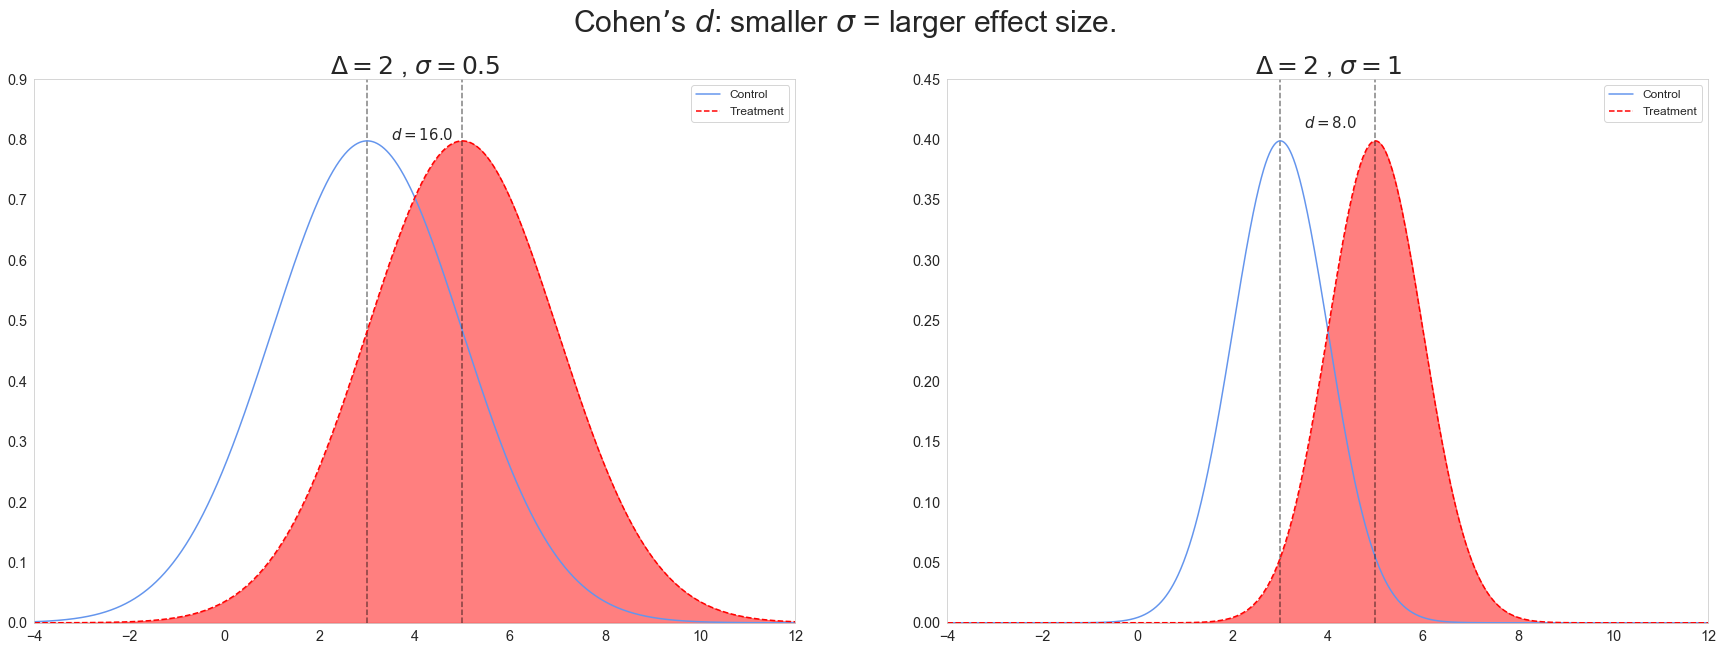

In [4]:
def plot_normal(mean,std,fill_between=False, **kwargs):
    variance = np.square(std)
    x = np.arange(-5,15,.01)
    plt.axvline(x= mean, color = "black", alpha=0.5,linestyle='--') 
    f = np.exp(-np.square(x-mean)/2*variance)/(np.sqrt(2*np.pi*variance))    
    if fill_between:
        plt.fill_between(x, f, color='red',alpha=0.5)
    plt.plot(x,f, **kwargs)
    
def compare(mean1,mean2,std,txty):
    d = (mean1 + mean2) / std
    plot_normal(mean1,std,  color='cornflowerblue', label='Control')
    plot_normal(mean2,std, fill_between = True, linestyle='--', color='red',label='Treatment')
    plt.text(x=(mean1+mean2)/2-0.5, y= txty,s = f'$d={d}$', fontsize=15)
    plt.grid(False)
    plt.legend()
    #plt.yticks([])
    
fig = plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 2, 1)


compare(3,5,0.5, txty=0.80)
plt.xlim([-4,12])
plt.ylim([0,0.9])
plt.title(f'$\Delta = 2$ , $\sigma = 0.5$',fontsize=25)

ax2 = plt.subplot(1, 2, 2)
compare(3,5,1, txty=0.41)
plt.xlim([-4,12])
plt.ylim([0,0.45])
plt.title(f'$\Delta = 2$ , $\sigma = 1$', fontsize=25)

plt.suptitle('Cohen’s $d$: smaller $\sigma$ = larger effect size.', fontsize=30)


------

# Power Analysis using Monte-Carlo simulation:

We normally want the desired power to be 0.8 ie. the probability of rejecting the null hypothesis when the alternative hypotheis is true to be 0.8

In [18]:
def plot_simulation(x,y,title,xaxis):
    plt.ylim([0,1.1])
    plt.xlim([0, y.max()+y.min()])
    plt.plot(y, x, c='black', linewidth='2')
    plt.scatter(y, x, c='r', s=40,alpha=0.5)
    plt.ylabel('Power')
    plt.xlabel(xaxis)
    plt.title(title)
    plt.axhline(y =0.8, color = "black", alpha=0.5,linestyle='--')
    plt.axhline(y =0.8, color = "black", alpha=0.5,linestyle='--')
    plt.grid(False)

In [16]:
#this is going to be our sampling paramter. 
#this is the function we wrote in 2_-testfromScratch.
from utils import t_statistic

from scipy.stats import norm, binom

sample_mean = 25
sample_sd = 10 #we are using larger standard deviation so that the power is not high enough early.
sample_data = norm.rvs(loc=sample_mean, scale=sample_sd, size=20000)

## Using varied sample sizes

In [17]:
sample_sizes = range(50, 10000, 100) # Sample sizes we will test over
alpha = 0.05 
simulations = 1000 #number of simulations per iteration
relative_effect = 1.03 #fixed relative effect 

power_dist = np.empty((len(sample_sizes), 2))
for i in range(0, len(sample_sizes)): 
    N = sample_sizes[i]
    
    control_data = sample_data[0:N]
    variant_data = control_data * relative_effect 
    
    sig_results = []
    for j in range(0, simulations):
        
        # Randomly allocate the sample data to the control and variant   
        control_sample = np.random.choice(control_data, N//2, replace=False)
        variant_sample =  np.random.choice(variant_data, N//2, replace=False)
        
        # Use Welch's t-test, make no assumptions on tests for equal variances
        _,_,p_val,_ = t_statistic(2, control_sample,variant_sample,alpha)
        
        #We are assuming the null hypothesis to be true, hence power would be the times we would get alpha value
        #we are rejecting the null hypothesis.
        sig_results.append(p_val <= alpha) 
    
    #getting the probability of rejecting the null hypothesis.
    power_dist[i,] = [N, np.mean(sig_results)] 
    
power, sample_sizes = power_dist[:,1], power_dist[:,0]

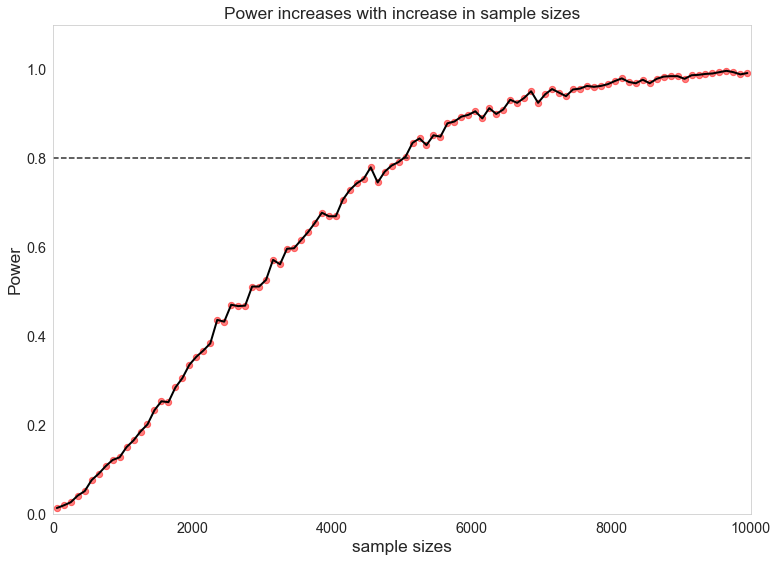

In [19]:
plot_simulation(power,sample_sizes,'Power increases with increase in sample sizes','sample sizes')

Size-Lehr's Equation:

__Rule of Thumb for number of sample sizes__

<font size=4>
$n = \frac{16}{\Delta ^{2}}$

where
$\Delta = \frac{\mu_{0} - \mu_{1}}{\sigma}$
</font>

# References/Resouces:

[Visualize Cohen's Effect size:](https://rpsychologist.com/d3/nhst/) <br>
[Statistical Rules of Thumb](http://www.vanbelle.org/chapters/webchapter2.pdf)